# Homework 3 — Deep Learning (RPI Spring 2026)


**Dataset:** UCI *Bank Marketing* (Portuguese bank direct marketing campaigns)
- **Type:** Classification (predict whether the client subscribes to a term deposit: `y`)
- **Size:** ~41k rows (bank-additional-full.csv)
- **Link:** https://archive.ics.uci.edu/dataset/222/bank+marketing

In [1]:
import os, zipfile, random, math
import numpy as np
import pandas as pd

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


## 1) Download and load the dataset


In [5]:
# !pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch dataset (id=222 = Bank Marketing)
bank_marketing = fetch_ucirepo(id=222)

# Features and target
X_df = bank_marketing.data.features
y_df = bank_marketing.data.targets

# Combine into one dataframe (optional but convenient)
df = pd.concat([X_df, y_df], axis=1)

df.head(), df.shape


(   age           job  marital  education default  balance housing loan  \
 0   58    management  married   tertiary      no     2143     yes   no   
 1   44    technician   single  secondary      no       29     yes   no   
 2   33  entrepreneur  married  secondary      no        2     yes  yes   
 3   47   blue-collar  married        NaN      no     1506     yes   no   
 4   33           NaN   single        NaN      no        1      no   no   
 
   contact  day_of_week month  duration  campaign  pdays  previous poutcome   y  
 0     NaN            5   may       261         1     -1         0      NaN  no  
 1     NaN            5   may       151         1     -1         0      NaN  no  
 2     NaN            5   may        76         1     -1         0      NaN  no  
 3     NaN            5   may        92         1     -1         0      NaN  no  
 4     NaN            5   may       198         1     -1         0      NaN  no  ,
 (45211, 17))

## 2) EDA / basic checks
- Target: `y` (yes/no)
- Features include both numeric and categorical variables.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df['y'].value_counts(normalize=True)

,proportion
y,
no,0.883015
yes,0.116985


In [8]:
df.isna().sum().sort_values(ascending=False).head(10)

,0
poutcome,36959
contact,13020
education,1857
job,288
age,0
default,0
balance,0
housing,0
marital,0
loan,0


## 3) Preprocessing: one-hot encode categoricals + standardize numerics
Convert the target `y` to 0/1, one-hot encode categorical columns, and standardize numeric columns.
Then do a **train / dev / test** split.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = (df['y'].astype(str).str.lower() == 'yes').astype(np.float32).to_numpy().reshape(-1, 1)
X_df = df.drop(columns=['y']).copy()

numeric_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_df.columns if c not in numeric_cols]

X_cat = pd.get_dummies(X_df[categorical_cols], drop_first=False)
X_num = X_df[numeric_cols].copy()

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

X = np.hstack([X_num_scaled, X_cat.to_numpy(dtype=np.float32)]).astype(np.float32)

print('X shape:', X.shape, 'y shape:', y.shape)


X shape: (45211, 47) y shape: (45211, 1)


In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=SEED, stratify=y
)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print('train:', X_train.shape, y_train.shape)
print('dev  :', X_dev.shape, y_dev.shape)
print('test :', X_test.shape, y_test.shape)


train: (27126, 47) (27126, 1)
dev  : (9042, 47) (9042, 1)
test : (9043, 47) (9043, 1)


## Part 1 — Neural network from scratch (NumPy only)
I implement a fully-connected NN:
**Input → Hidden (ReLU) → Output (Sigmoid)** for binary classification.

Included:
- `__init__`, `forward`, `backward`, `train` (mini-batch GD), `cost` (BCE), `predict`


In [11]:
class NeuralNetwork:
    """2-layer NN (1 hidden layer) from scratch using NumPy."""
    def __init__(self, n_inputs: int, n_hidden: int = 64, lr: float = 0.05,
                 l2: float = 0.0, seed: int = 42):
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.lr = lr
        self.l2 = l2

        rng = np.random.default_rng(seed)
        self.W1 = rng.normal(0, np.sqrt(2.0 / n_inputs), size=(n_inputs, n_hidden)).astype(np.float32)
        self.b1 = np.zeros((1, n_hidden), dtype=np.float32)
        self.W2 = rng.normal(0, np.sqrt(1.0 / n_hidden), size=(n_hidden, 1)).astype(np.float32)
        self.b2 = np.zeros((1, 1), dtype=np.float32)
        self.cache = {}

    @staticmethod
    def relu(z):
        return np.maximum(0.0, z)

    @staticmethod
    def relu_grad(z):
        return (z > 0).astype(np.float32)

    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -50, 50)
        return 1.0 / (1.0 + np.exp(-z))

    def forward(self, X: np.ndarray) -> np.ndarray:
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        A2 = self.sigmoid(Z2)
        self.cache = {'X': X, 'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
        return A2

    def cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        eps = 1e-7
        y_pred = np.clip(y_pred, eps, 1 - eps)
        m = y_true.shape[0]
        bce = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()
        if self.l2 > 0:
            l2_term = (self.l2 / (2 * m)) * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
            return float(bce + l2_term)
        return float(bce)

    def backward(self, y_true: np.ndarray):
        X = self.cache['X']
        Z1 = self.cache['Z1']
        A1 = self.cache['A1']
        A2 = self.cache['A2']
        m = y_true.shape[0]

        dZ2 = (A2 - y_true).astype(np.float32)
        dW2 = (A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_grad(Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        if self.l2 > 0:
            dW2 += (self.l2 / m) * self.W2
            dW1 += (self.l2 / m) * self.W1

        return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

    def step(self, grads):
        self.W1 -= self.lr * grads['dW1']
        self.b1 -= self.lr * grads['db1']
        self.W2 -= self.lr * grads['dW2']
        self.b2 -= self.lr * grads['db2']

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        probs = self.forward(X)
        return (probs >= threshold).astype(np.int32)

    @staticmethod
    def accuracy(y_true: np.ndarray, y_hat: np.ndarray) -> float:
        return float((y_true.astype(np.int32) == y_hat).mean())

    def train(self, X_train, y_train, X_dev=None, y_dev=None,
              epochs: int = 30, batch_size: int = 256, verbose: bool = True):
        n = X_train.shape[0]
        hist = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

        for epoch in range(1, epochs + 1):
            idx = np.random.permutation(n)
            X_shuf, y_shuf = X_train[idx], y_train[idx]

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                Xb, yb = X_shuf[start:end], y_shuf[start:end]
                y_pred = self.forward(Xb)
                grads = self.backward(yb)
                self.step(grads)

            tr_probs = self.forward(X_train)
            tr_loss = self.cost(y_train, tr_probs)
            tr_pred = (tr_probs >= 0.5).astype(np.int32)
            tr_acc = self.accuracy(y_train, tr_pred)

            hist['train_loss'].append(tr_loss)
            hist['train_acc'].append(tr_acc)

            if X_dev is not None and y_dev is not None:
                dv_probs = self.forward(X_dev)
                dv_loss = self.cost(y_dev, dv_probs)
                dv_pred = (dv_probs >= 0.5).astype(np.int32)
                dv_acc = self.accuracy(y_dev, dv_pred)
                hist['dev_loss'].append(dv_loss)
                hist['dev_acc'].append(dv_acc)

                if verbose and (epoch == 1 or epoch % 5 == 0 or epoch == epochs):
                    print(f"Epoch {epoch:02d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | dev loss {dv_loss:.4f} acc {dv_acc:.4f}")
            else:
                if verbose and (epoch == 1 or epoch % 5 == 0 or epoch == epochs):
                    print(f"Epoch {epoch:02d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.4f}")

        return hist


In [12]:
nn = NeuralNetwork(n_inputs=X_train.shape[1], n_hidden=64, lr=0.05, l2=1e-4, seed=SEED)
history = nn.train(X_train, y_train, X_dev=X_dev, y_dev=y_dev, epochs=30, batch_size=256, verbose=True)


Epoch 01/30 | train loss 0.2946 acc 0.8875 | dev loss 0.2961 acc 0.8856
Epoch 05/30 | train loss 0.2553 acc 0.8914 | dev loss 0.2564 acc 0.8931
Epoch 10/30 | train loss 0.2417 acc 0.8952 | dev loss 0.2436 acc 0.8960
Epoch 15/30 | train loss 0.2340 acc 0.8976 | dev loss 0.2366 acc 0.8966
Epoch 20/30 | train loss 0.2291 acc 0.8992 | dev loss 0.2323 acc 0.8977
Epoch 25/30 | train loss 0.2250 acc 0.9005 | dev loss 0.2289 acc 0.8986
Epoch 30/30 | train loss 0.2220 acc 0.9017 | dev loss 0.2263 acc 0.8997


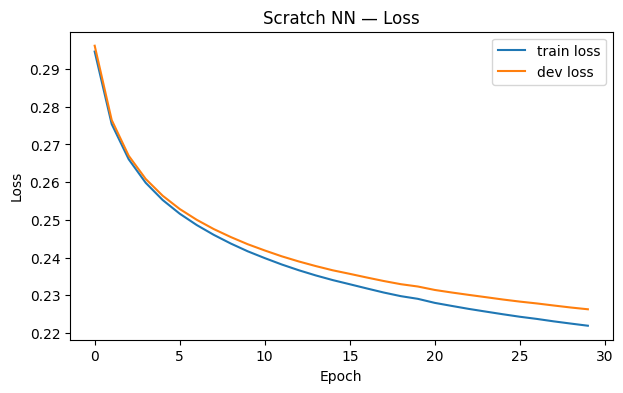

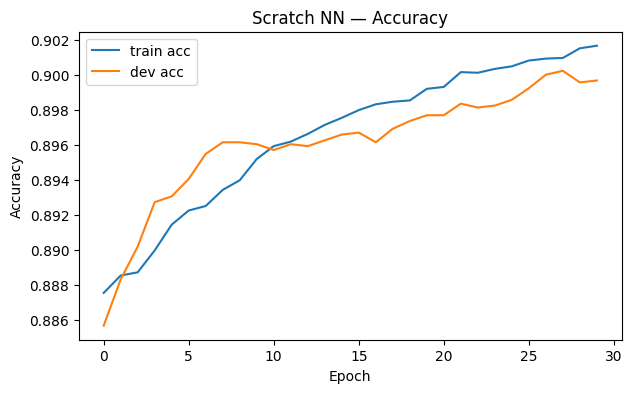

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['dev_loss'], label='dev loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Scratch NN — Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['dev_acc'], label='dev acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Scratch NN — Accuracy')
plt.legend()
plt.show()


In [14]:
test_probs = nn.forward(X_test)
test_pred = (test_probs >= 0.5).astype(np.int32)
print('Scratch NN test loss:', round(nn.cost(y_test, test_probs), 4))
print('Scratch NN test accuracy:', round(nn.accuracy(y_test, test_pred), 4))


Scratch NN test loss: 0.2202
Scratch NN test accuracy: 0.902


## Part 2 — 2-layer neural network using a Deep Learning framework (PyTorch)
Resources:
1. PyTorch Build the Neural Network tutorial: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
2. PyTorch Autograd tutorial: https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html
3. torch.optim docs: https://pytorch.org/docs/stable/optim.html
4. torch.nn loss docs: https://pytorch.org/docs/stable/nn.html#loss-functions


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


In [16]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_dev_t   = torch.tensor(X_dev, dtype=torch.float32)
y_dev_t   = torch.tensor(y_dev, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

batch_size = 256
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
dev_loader   = DataLoader(TensorDataset(X_dev_t, y_dev_t),     batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t),   batch_size=batch_size, shuffle=False)

X_train_t.shape, y_train_t.shape


(torch.Size([27126, 47]), torch.Size([27126, 1]))

In [17]:
class TwoLayerNet(nn.Module):
    def __init__(self, n_inputs: int, n_hidden: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [18]:
def evaluate(model, loader):
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()
    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            total_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).int()
            total_correct += (preds == yb.int()).sum().item()
            total_n += xb.size(0)
    return total_loss / total_n, total_correct / total_n

def train_pytorch(model, train_loader, dev_loader, epochs=20, lr=1e-3, weight_decay=1e-4):
    model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    hist = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}
    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
        tr_loss, tr_acc = evaluate(model, train_loader)
        dv_loss, dv_acc = evaluate(model, dev_loader)
        hist['train_loss'].append(tr_loss)
        hist['train_acc'].append(tr_acc)
        hist['dev_loss'].append(dv_loss)
        hist['dev_acc'].append(dv_acc)
        if epoch == 1 or epoch % 5 == 0 or epoch == epochs:
            print(f"Epoch {epoch:02d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | dev loss {dv_loss:.4f} acc {dv_acc:.4f}")
    return hist

pt_model = TwoLayerNet(n_inputs=X_train.shape[1], n_hidden=64)
pt_hist = train_pytorch(pt_model, train_loader, dev_loader, epochs=20, lr=1e-3, weight_decay=1e-4)


Epoch 01/20 | train loss 0.2714 acc 0.8887 | dev loss 0.2714 acc 0.8874
Epoch 05/20 | train loss 0.2224 acc 0.9023 | dev loss 0.2245 acc 0.9026
Epoch 10/20 | train loss 0.2129 acc 0.9064 | dev loss 0.2171 acc 0.9038
Epoch 15/20 | train loss 0.2042 acc 0.9102 | dev loss 0.2111 acc 0.9062
Epoch 20/20 | train loss 0.1974 acc 0.9123 | dev loss 0.2081 acc 0.9077


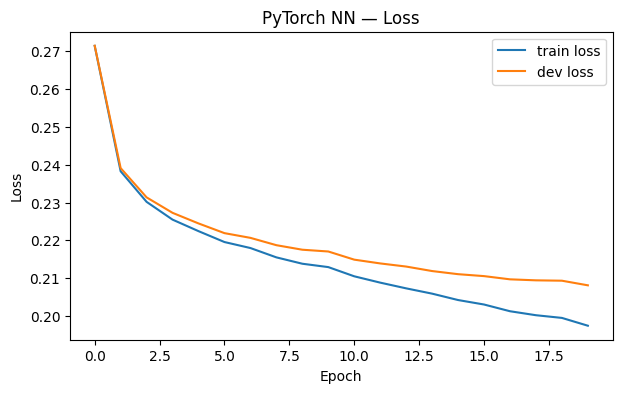

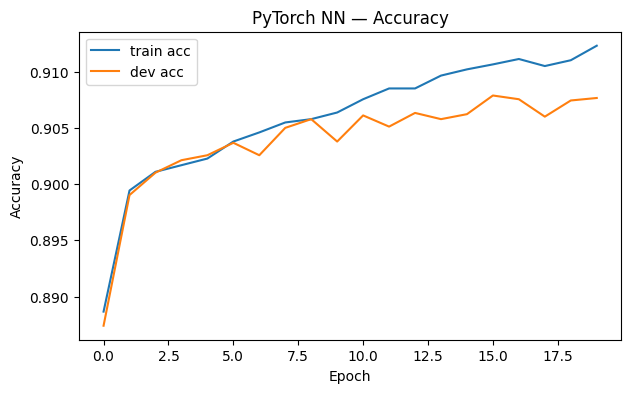

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(pt_hist['train_loss'], label='train loss')
plt.plot(pt_hist['dev_loss'], label='dev loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PyTorch NN — Loss')
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(pt_hist['train_acc'], label='train acc')
plt.plot(pt_hist['dev_acc'], label='dev acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('PyTorch NN — Accuracy')
plt.legend()
plt.show()


In [20]:
test_loss, test_acc = evaluate(pt_model, test_loader)
print('PyTorch NN test loss:', round(test_loss, 4))
print('PyTorch NN test accuracy:', round(test_acc, 4))


PyTorch NN test loss: 0.203
PyTorch NN test accuracy: 0.9099


## Task 3 — Hyperparameter Selection Explanation

For the PyTorch model, I chose 64 hidden units as a good starting size for a small tabular dataset. It is large enough to capture nonlinear patterns but not so large that it becomes unnecessarily complex.

I used the Adam optimizer with a learning rate of 0.001. Adam was chosen because it automatically adjusts learning rates during training and typically converges faster and more reliably than basic gradient descent.

Training was done using mini-batch gradient descent with a batch size of 256. Mini-batching improves runtime efficiency compared to full-batch training and makes learning more stable.

I also used L2 regularization (weight decay = 1e-4) to help prevent overfitting. Since the dataset contains many one-hot encoded features, regularization helps the model generalize better to new data.

Hyperparameters were selected based on validation performance by monitoring loss and accuracy during training.